In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df= pd.read_csv("uber.csv")
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]) 
df.drop(["Unnamed: 0", "key"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        200000 non-null  float64            
 1   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   200000 non-null  float64            
 3   pickup_latitude    200000 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 10.7 MB


In [3]:
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [4]:
df.drop(["pickup_datetime"], axis=1, inplace=True)

In [5]:
df.isnull().sum()
df.dropna(inplace=True)

## Correlation Matrix Heatmap

- If two variables show a strong positive correlation (e.g., close to 1), they move together in the same direction. For instance, if one variable increases, the other tends to increase as well.

- If two variables have a strong negative correlation (e.g., close to -1), they move in opposite directions. As one variable increases, the other tends to decrease.

- A correlation close to 0 suggests little to no linear relationship between the two variables.


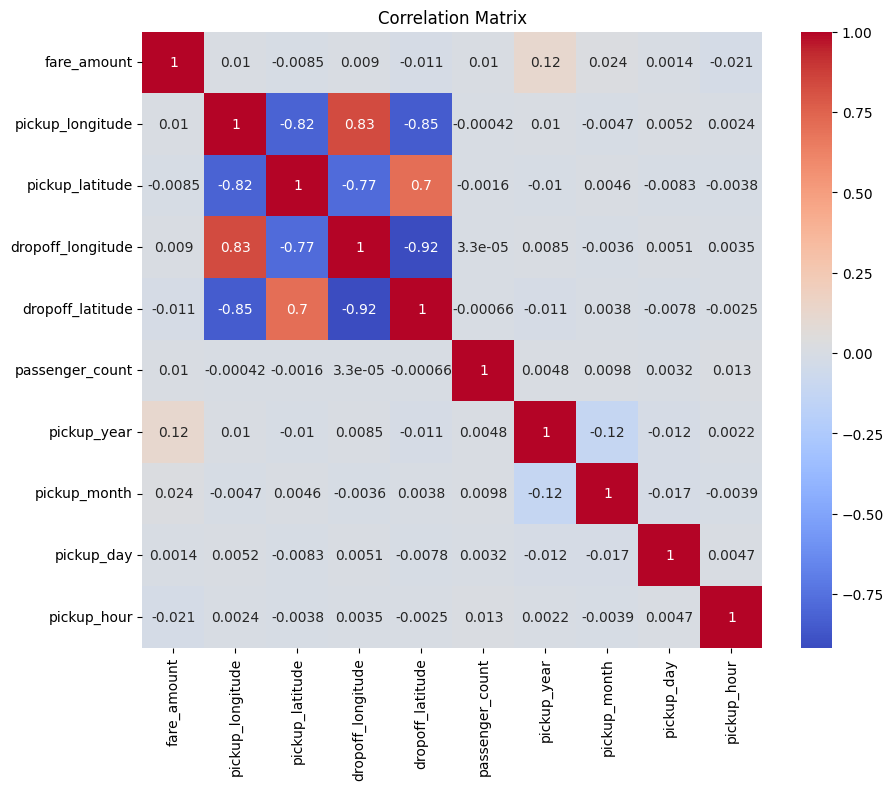

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [7]:
from geopy.distance import great_circle
valid_entries = df[
    df['pickup_latitude'].between(-90, 90) & 
    df['pickup_longitude'].between(-180, 180) &
    df['dropoff_latitude'].between(-90, 90) & 
    df['dropoff_longitude'].between(-180, 180)
]
df = df.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])


def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return great_circle(pickup, dropoff).kilometers

df['distance'] = valid_entries.apply(calculate_distance, axis=1)

In [8]:
df = df.interpolate(method="linear")

In [9]:
df.drop(df[df.distance > 50].index, inplace=True)
df.drop(df[df.distance < 0.1].index, inplace=True)
df.drop(df[df.fare_amount <= 0].index, inplace=True)

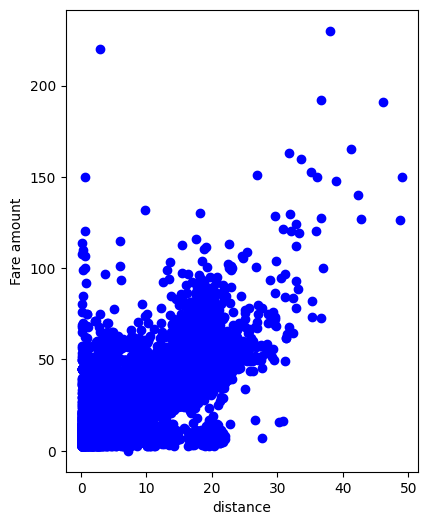

In [10]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(df.distance, df['fare_amount'], color='blue')
plt.xlabel('distance')
plt.ylabel('Fare amount')
plt.show()

In [11]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.isnull().sum()

passenger_count    0
pickup_year        0
pickup_month       0
pickup_day         0
pickup_hour        0
distance           0
dtype: int64

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [16]:
y_pred_lin = lin_reg.predict(X_test_scaled)
y_pred_ridge = ridge_reg.predict(X_test_scaled)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

def evaluate_model(y_test, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - RMSE: {rmse}, R2: {r2}")

evaluate_model(y_test, y_pred_lin, "Linear Regression")

evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression - RMSE: 3.925106279381163, R2: 0.8175052380994259
Ridge Regression - RMSE: 3.9251049571297956, R2: 0.8175053610535019
Lasso Regression - RMSE: 3.927291740453798, R2: 0.8173019588995876


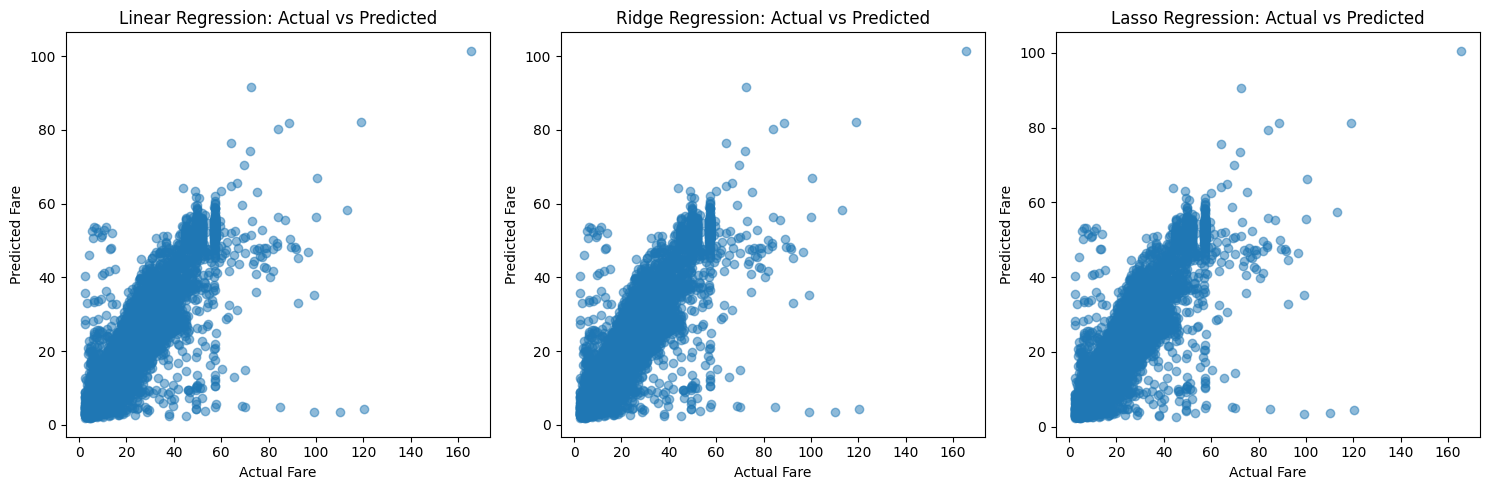

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lin, alpha=0.5)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.title("Ridge Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.title("Lasso Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.tight_layout()
plt.show()